# Assignment 04


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

In [3]:
datasets_dir = Path('../../../datasets')
# ls ../../

In [4]:
datasets_dir

PosixPath('../../../datasets')

In [5]:
moscow_gdb_path = datasets_dir / 'moscow' / 'moscow_vectors' / 'Moscow.gdb'
print(moscow_gdb_path)
print(type(moscow_gdb_path))

../../../datasets/moscow/moscow_vectors/Moscow.gdb
<class 'pathlib.PosixPath'>


In [6]:
import fiona
moscow_gdb = str(moscow_gdb_path)

fiona.listlayers(moscow_gdb)

['Moscow_Zoning',
 'Centerlines',
 'Moscow_Parks',
 'Moscow_City_Limit',
 'Parcels']

In [7]:
parcels = gpd.read_file(moscow_gdb, layer='Parcels')
roads = gpd.read_file(moscow_gdb, layer='Centerlines')
zoning = gpd.read_file(moscow_gdb, layer='Moscow_Zoning')
city_limits = gpd.read_file(moscow_gdb, layer='Moscow_City_Limit')
parks = gpd.read_file(moscow_gdb, layer='Moscow_Parks')


In [8]:
parcels.columns

Index(['LABEL', 'PM_PAR_14', 'PM_MAIL_NM', 'PM_MAIL_A1', 'PM_MAIL_A2',
       'PM_MAIL_CT', 'PM_MAIL_ST', 'PM_MAIL_ZP', 'PM_PROP_AD', 'PM_DEEDCDT',
       'PM_DEEDRF1', 'PM_DEEDRF2', 'PM_DEEDRF3', 'PM_DEEDRF4', 'PM_DEEDRF5',
       'PM_TAX_AMT', 'PM_PV_AREA', 'PM_PV_NBHD', 'PM_PV_ACRE', 'PM_TOT_VAL',
       'PM_IMP_VAL', 'PM_LND_VAL', 'PM_EX_VAL', 'PM_NET_VAL', 'PM_CATS',
       'LG_LINE_1', 'LG_LINE_2', 'LG_LINE_3', 'LG_LINE_4', 'LG_LINE_5',
       'LG_LINE_6', 'PM_PARC_CD', 'GlobalID', 'Shape_Length', 'Shape_Area',
       'geometry'],
      dtype='object')

### Shapely geometries
Behind the scenes, geopandas is reading in vector data, storing the attribute tables as `pandas` dataframes,
and storing the vector geometry as `shapely` geometries.


### Reading:
To become more familiar with vector operations in geopandas/shapely, 
read this introduction to shapely geometries carefully, 
and reproduce/experiment with the code in this reading from within a blank notebook:
https://towardsdatascience.com/geospatial-adventures-step-1-shapely-e911e4f86361

Read this page for a more comprehensive description of `shapely` geometries: 
https://autogis-site.readthedocs.io/en/latest/notebooks/L1/geometric-objects.html

Scroll through the `shapely` user manual (https://shapely.readthedocs.io/en/stable/manual.html), 
reviewing the different functions that shapely includes.  `geopandas` allows all of these functions to be
executed, [directly through `geopandas`, without explicit call to `shapely`](https://geopandas.org/docs/user_guide/geometric_manipulations.html).  `shapely` is just running
quietly under the hood.  Pay specific attention to the "Spatial Analysis Methods" of the manual.

In [9]:
from shapely.geometry import LineString
line = LineString([(0, 0), (1, 1), (2, 0)])
print('Line area =', line.area)
print('Line length =', line.length)

Line area = 0.0
Line length = 2.8284271247461903


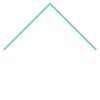

In [10]:
line

In [ ]:
type(line)

In [ ]:
print( list(line.coords) )
print( line.coords[2] )

<div class="alert alert-block alert-warning">

## 1. Shapely geometries
What `shapely` geometry are each of the parcels in the Moscow parcels layer? What `shapely` geometry are their centroids?
    
Find the Kenworthy Theater within the parcels database (hint: the name field for its mailing address, 
    PM_MAIL_NM, is "KENWORTHY PERFORMING ARTS CTR").
What are the coordinates for the corners of its parcel?    
</div>


In [ ]:

print(parcels[parcels.PM_MAIL_NM == "KENWORTHY PERFORMING ARTS CTR"].geometry.values[0].geoms[0])

In [13]:
parcels[parcels.PM_MAIL_NM == "KENWORTHY PERFORMING ARTS CTR"]

,LABEL,PM_PAR_14,PM_MAIL_NM,PM_MAIL_A1,PM_MAIL_A2,PM_MAIL_CT,PM_MAIL_ST,PM_MAIL_ZP,PM_PROP_AD,PM_DEEDCDT,...,LG_LINE_2,LG_LINE_3,LG_LINE_4,LG_LINE_5,LG_LINE_6,PM_PARC_CD,GlobalID,Shape_Length,Shape_Area,geometry
1359,002B,RPM0001005002B,KENWORTHY PERFORMING ARTS CTR,508 S MAIN,,MOSCOW,ID,83843.0,508 S MAIN,20010202.0,...,"BLK 5 LOT 2, N 1/2 OF LOT 3",EXEMPT,,,,C,{A4FB5B11-A87D-453A-ABD6-8BC607A17A20},369.999919,7499.997375,"MULTIPOLYGON (((2311036.946 1848531.880, 23110..."


In [31]:
parcels[parcels.PM_MAIL_NM == "KENWORTHY PERFORMING ARTS CTR"].geometry[0]

KeyError: 0

In [16]:
parcels[parcels.PM_MAIL_NM == "KENWORTHY PERFORMING ARTS CTR"].geometry.to_numpy()

array([<shapely.geometry.multipolygon.MultiPolygon object at 0x14880c910>],
      dtype=object)

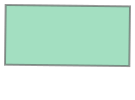

In [18]:
parcels[parcels.PM_MAIL_NM == "KENWORTHY PERFORMING ARTS CTR"].geometry.to_numpy()[0]

In [20]:
type(parcels[parcels.PM_MAIL_NM == "KENWORTHY PERFORMING ARTS CTR"].geometry.to_numpy()[0])

shapely.geometry.multipolygon.MultiPolygon

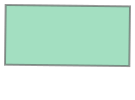

In [22]:
parcels[parcels.PM_MAIL_NM == "KENWORTHY PERFORMING ARTS CTR"].geometry.to_numpy()[0].geoms[0]

In [23]:
print(parcels[parcels.PM_MAIL_NM == "KENWORTHY PERFORMING ARTS CTR"].geometry.to_numpy()[0].geoms[0])

POLYGON ((2311036.945908163 1848531.879651986, 2311036.277274329 1848471.883380905, 2310911.285070244 1848473.276094653, 2310911.953704078 1848533.272365741, 2311036.945908163 1848531.879651986))


In [24]:
parcels[parcels.PM_MAIL_NM == "KENWORTHY PERFORMING ARTS CTR"].geometry.to_numpy()[0].geoms[0].coords

NotImplementedError: Component rings have coordinate sequences, but the polygon does not

https://www.google.com/search?client=firefox-b-1-d&q=coords+of+a+polygon+shapely

In [25]:
list(parcels[parcels.PM_MAIL_NM == "KENWORTHY PERFORMING ARTS CTR"].geometry.to_numpy()[0].geoms[0].exterior.coords)

[(2311036.9459081627, 1848531.879651986),
 (2311036.277274329, 1848471.8833809048),
 (2310911.285070244, 1848473.2760946527),
 (2310911.9537040778, 1848533.2723657414),
 (2311036.9459081627, 1848531.879651986)]

In [ ]:
import shapely
help(shapely.geometry.polygon)

In [ ]:
i = 2 # Look at one park, for example
print(parks.iloc[i])

buffer_radius = 200 # What are the units for this?

buffered_park = parks.iloc[i:i+1].buffer(buffer_radius) # Careful!  I'm not sure why this is, but geopandas requires a slice here, not a single index
    #If you use just one index, it seems to remove all the geopandas properties of the data
buffered_park.plot()



<div class="alert alert-block alert-warning">

## 2. Identifying Moscow residents underserved by city parks.
You're an urban planner consulting with the City of Moscow.  The city is interested in increasing the number of parks
    within the city, and better designing those parks to meet the needs of those who are currently underserved
    by the city's existing parks.  The city wants to begin the planning process by reaching out to these currently
    underserved residents, but first the city needs to know who they are.
    
The city asks you to produce a list of all resident addresses within the city limits whose property is at least 1000 feet
    from a current park.
    
To properly address the letters and questionaires that the city will be sending out, the city would like this list
    of residents as a csv file, with each property address on a separate line (property addresses are represented within
    the parcels database by the field name "PM_PROP_AD").  Produce this file and a map of the underserved parcels.
    


</div>

In [ ]:
%matplotlib widget

fig, ax = plt.subplots()
parks.buffer(buffer_radius).plot(ax=ax, color='g')
# city_limits.plot(ax=ax, color=None, edgecolor='r')
roads.plot(ax=ax)

ax.set_xlim( city_limits.bounds.to_numpy()[0][::2] )
ax.set_ylim( city_limits.bounds.to_numpy()[0][1::2] )

In [ ]:
roads

In [ ]:
zoning.columns

In [ ]:
zoning['LANDUSEDESC'].unique()

In [ ]:
zoning['LANDUSECODE'].unique()

In [ ]:
# We can measure the distance between any parcel and a point near the center of downtown Moscow
from shapely.geometry import Point
parcels['Dwntn_dist'] = parcels.distance(Point(2.311e6, 1.849e6))

#### Visualizing the data
I think each of the plots below is interesting.  Try commenting and uncommenting each one

In [ ]:
%matplotlib widget
fig, ax = plt.subplots( figsize=(8,8) )

# These are a few of the interesting plots to look at.
# parcels.plot(column='Dwntn_dist', ax=ax, legend=True, vmax=5280);
zoning.plot(column='LANDUSEDESC', ax=ax, legend=True, cmap='tab20')
# parcels.plot(column= 'SaleYear', ax=ax, legend=True, vmin=1990)

ax.set_xlim( city_limits.bounds.to_numpy()[0][::2] )
ax.set_ylim( city_limits.bounds.to_numpy()[0][1::2] )

roads.plot(ax=ax, color='gray')


### Property sales over time
Similar to the assignment from last week, we can look at the property sales as a function of time.

In [ ]:
import pandas as pd
print( parcels['PM_DEEDCDT'].astype(str)[:4] )

parcels['SaleDate'] = pd.to_datetime(
    parcels['PM_DEEDCDT'], 
    errors='coerce', 
    format='%Y%m%d')


In [ ]:
parcels['SaleDate']

In [ ]:
dates = parcels['PM_DEEDCDT'].to_numpy() # Pull out all the sale dates (initially floats)
yr = np.full( dates.shape, np.nan ) # initialize a variable full of nans

for i in range(len(dates)): 
    if dates[i] > 0:
        yr[i] = int( str(dates[i])[:4] )
    else:
        yr[i] = np.nan

parcels['SaleYear'] = yr # Create a new column for the parcels data frame representing sale year


In [ ]:
bin_size = np.timedelta64(365, 'D')/12 # days
fig, ax = plt.subplots()
ax.hist(parcels['SaleDate'], bins=np.arange(np.datetime64('1990-01-01'), 
                                            np.datetime64('2022-01-01'), 
                                            bin_size ) )
ylabel_text = 'Number of property sales in Moscow\nper ' + str(bin_size.astype(int)) + ' days'
ax.set_ylabel(ylabel_text)
ax.set_xlim(np.datetime64('2000-01-01'), np.datetime64('2022-01-01') );
# ax.set_xlim(np.datetime64('2010-12-15'), np.datetime64('2011-01-01') )

# Note that the sales at the end of 2010 are anomalous, and are all recorded on the same day.
# That's suspicious and Tim thinks that it must be some change in accounting or record keeping.

<div class="alert alert-block alert-warning">

## 3. Investing in downtown property
You are the GIS consultant for a property investment company that specializes in
downtown and higher-density properties.  Your company is considering Moscow real estate.
You've heard about the boom in sales within the city, and your company would like to know how competitive
property purchasing will be, or if they will be able to drive a hard bargin.

Has the downtown property market heated up as much as within the city as a whole?
Compare sale rates within two of the zoned downtown regions with those of the city as a whole.
    
Is there anything else in these data that you would like to share with your colleagues
    that could help advise them as you consider this investment?
</div>

<div class="alert alert-block alert-warning">

## 4. Find, plot, work with data of your own
Find a spatial, vector dataset of your choosing (by googling, from another class, 
    or from a research project of yours). This could be climate data, geologic units,
    census data, ecological units, demographic data, etc. Download or copy this dataset
    into the current directory, plot it, and use geopandas to draw on the attributes 
    of that data (even just lengths, areas, etc) and tell me something about that data.
</div>